In [1]:
import numpy as np
import tensorflow as tf
from data_load import make_environments
import matplotlib.pyplot as plt
import seaborn as sns

envs, test = make_environments()

In [2]:
x_train, y_train = envs[1]
x_test, y_test = test

In [3]:
biased = tf.keras.Sequential(
    [tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1)]
)

biased.compile(optimizer='Adagrad', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                         metrics=tf.keras.metrics.BinaryAccuracy(threshold=0), )

biased.fit(x = x_train, y = y_train, batch_size=250, epochs=40, verbose = 0)
biased.evaluate(x = x_test, y = y_test)

313/313 [==============================] - 0s 556us/step - loss: 1.1315 - binary_accuracy: 0.1037


[1.1314858198165894, 0.10369999706745148]

In [4]:
logits_train = biased(x_train)
p_train = 1/(1 + np.exp(-logits_train))
loss_train = tf.keras.losses.binary_crossentropy(y_train.reshape((-1, 1)), logits_train, from_logits = True).numpy().reshape((-1, ))
logits_train = logits_train.numpy().reshape((-1,))

/Users/smaity/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

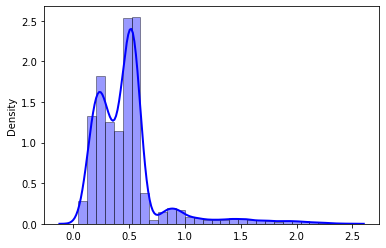

In [5]:
sns.distplot(loss_train, hist=True, kde=True, 
             bins=30, color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

(array([ 50., 257., 546., 630., 499., 311., 201., 116.,  50.,  15.,   3.,
          2.,   8.,  40.,  63.,  61.,  48.,  23.,  14.,   7.]),
 array([0.04523577, 0.10041764, 0.1555995 , 0.21078137, 0.26596323,
        0.3211451 , 0.37632698, 0.43150884, 0.4866907 , 0.54187256,
        0.5970544 , 0.6522363 , 0.70741814, 0.7626    , 0.81778187,
        0.8729638 , 0.92814565, 0.9833275 , 1.0385094 , 1.0936912 ,
        1.1488731 ], dtype=float32),
 <BarContainer object of 20 artists>)

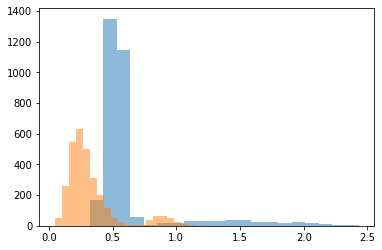

In [6]:
plt.hist(loss_train[y_train == 0], alpha = 0.5, bins = 20)
plt.hist(loss_train[y_train == 1], alpha = 0.5, bins = 20)

In [7]:
from sklearn.cluster import SpectralClustering
cluster = SpectralClustering(n_clusters=2, assign_labels='kmeans')
cluster.fit(logits_train.reshape((-1, 1)))
cluster_labels = cluster.labels_
np.mean(cluster_labels)

0.48383333333333334

/Users/smaity/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/smaity/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

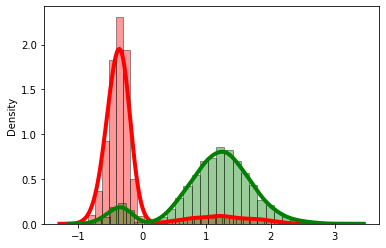

In [8]:
sns.distplot(logits_train[y_train == 0], hist=True, kde=True, 
             bins=30, color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(logits_train[y_train == 1], hist=True, kde=True, 
             bins=30, color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})


In [58]:
cluster_labels = cluster_labels.astype('float32')
cluster_predictor = tf.keras.Sequential(
    [tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1)]
)

cluster_predictor.compile(optimizer='Adagrad', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                         metrics=tf.keras.metrics.BinaryAccuracy(threshold=0), )

cluster_predictor.fit(x = x_train, y = cluster_labels, batch_size=250, epochs=40, verbose = 1)

cluster_predictor.save(filepath='cluster_predictor')


Epoch 1/40
24/24 [==============================] - 0s 1ms/step - loss: 0.6821 - binary_accuracy: 0.4948
Epoch 2/40
24/24 [==============================] - 0s 1ms/step - loss: 0.6634 - binary_accuracy: 0.5038
Epoch 3/40
24/24 [==============================] - 0s 1ms/step - loss: 0.6431 - binary_accuracy: 0.5296
Epoch 4/40
24/24 [==============================] - 0s 1ms/step - loss: 0.6256 - binary_accuracy: 0.5440
Epoch 5/40
24/24 [==============================] - 0s 1ms/step - loss: 0.6055 - binary_accuracy: 0.5837
Epoch 6/40
24/24 [==============================] - 0s 1ms/step - loss: 0.5875 - binary_accuracy: 0.6152
Epoch 7/40
24/24 [==============================] - 0s 1ms/step - loss: 0.5703 - binary_accuracy: 0.6632
Epoch 8/40
24/24 [==============================] - 0s 1ms/step - loss: 0.5490 - binary_accuracy: 0.7162
Epoch 9/40
24/24 [==============================] - 0s 1ms/step - loss: 0.5344 - binary_accuracy: 0.7587
Epoch 10/40
24/24 [==============================] - 0s

$\dot{x}(t) = - (2y - 1) \frac{\langle \nabla f(x), \nabla g(x)\rangle \nabla g(x)}{\|\nabla g(x)\|_2^2}$

In [52]:
adv_network = tf.keras.Sequential(
    [tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1)]
)



batch_size = 250
gradient_attacks = 20
gradient_attack_step = 0.1
steps = 10000
learning_rate = 0.5


X_train = tf.cast(x_train, dtype = tf.float32)
Y_train = tf.cast(y_train.reshape((-1, 1)), dtype = tf.float32)



batch = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
batch = batch.repeat().shuffle(5000).batch(batch_size).prefetch(1)
batch = batch.take(steps)

optimizer = tf.optimizers.Adagrad(learning_rate)


In [53]:

def adv_gradient(f, g, x, y):
    with tf.GradientTape(persistent=True) as grad:
        grad.watch(x)
        logit_y = f(x)
        logit_z = g(x)

    p = tf.sigmoid(logit_y)
    df = grad.gradient(logit_y, x)
    dg = grad.gradient(logit_z, x)
    dg, _ =  tf.linalg.normalize(dg, axis = 1)
    dot_df_dg = tf.reduce_sum(df * dg, axis = 1)
    return tf.reshape(tf.reshape((p - y), (-1, )) * dot_df_dg, (-1, 1)) * dg

In [54]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
ba = tf.keras.metrics.BinaryAccuracy(threshold=0)


for step, (x, y) in enumerate(batch, 1):

    if step > 200:
        for i in range(gradient_attacks):
            x = x + gradient_attack_step * adv_gradient(adv_network, cluster_predictor, x, y)/((i+1) ** (2/3))

    with tf.GradientTape() as g_adv_net:
        loss_batch = bce(y, adv_network(x))

    trainable_variables = adv_network.trainable_variables
    gradients = g_adv_net.gradient(loss_batch, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    if step % 200 == 0:
        test_error = ba(y_test.reshape((-1, 1)), adv_network(x_test)).numpy()
        print(f'Test accuracy after {step} step is {test_error}')



    

Test accuracy after 200 step is 0.11429999768733978
Test accuracy after 400 step is 0.3093999922275543
Test accuracy after 600 step is 0.37443333864212036
Test accuracy after 800 step is 0.4069499969482422
Test accuracy after 1000 step is 0.42645999789237976
Test accuracy after 1200 step is 0.439466655254364
Test accuracy after 1400 step is 0.448757141828537
Test accuracy after 1600 step is 0.4557250142097473
Test accuracy after 1800 step is 0.46114444732666016
Test accuracy after 2000 step is 0.4654799997806549
Test accuracy after 2200 step is 0.4690272808074951
Test accuracy after 2400 step is 0.4719833433628082
Test accuracy after 2600 step is 0.4744846224784851
Test accuracy after 2800 step is 0.4766285717487335
Test accuracy after 3000 step is 0.47848665714263916
Test accuracy after 3200 step is 0.4801124930381775
Test accuracy after 3400 step is 0.4815470576286316
Test accuracy after 3600 step is 0.4828222095966339
Test accuracy after 3800 step is 0.48396316170692444
Test accurac

KeyboardInterrupt: 

In [55]:
import itertools
gradient_attacks_v = [10, 20, 30]
gradient_attack_step_v = [10, 1, 0.1]
steps_v = [10000, 20000]
learning_rate_v = [1, 0.1, 0.01]

grid = list(itertools.product(gradient_attacks_v, gradient_attack_step_v, steps_v, learning_rate_v))

In [56]:
grid

[(10, 10, 10000, 1),
 (10, 10, 10000, 0.1),
 (10, 10, 10000, 0.01),
 (10, 10, 20000, 1),
 (10, 10, 20000, 0.1),
 (10, 10, 20000, 0.01),
 (10, 1, 10000, 1),
 (10, 1, 10000, 0.1),
 (10, 1, 10000, 0.01),
 (10, 1, 20000, 1),
 (10, 1, 20000, 0.1),
 (10, 1, 20000, 0.01),
 (10, 0.1, 10000, 1),
 (10, 0.1, 10000, 0.1),
 (10, 0.1, 10000, 0.01),
 (10, 0.1, 20000, 1),
 (10, 0.1, 20000, 0.1),
 (10, 0.1, 20000, 0.01),
 (20, 10, 10000, 1),
 (20, 10, 10000, 0.1),
 (20, 10, 10000, 0.01),
 (20, 10, 20000, 1),
 (20, 10, 20000, 0.1),
 (20, 10, 20000, 0.01),
 (20, 1, 10000, 1),
 (20, 1, 10000, 0.1),
 (20, 1, 10000, 0.01),
 (20, 1, 20000, 1),
 (20, 1, 20000, 0.1),
 (20, 1, 20000, 0.01),
 (20, 0.1, 10000, 1),
 (20, 0.1, 10000, 0.1),
 (20, 0.1, 10000, 0.01),
 (20, 0.1, 20000, 1),
 (20, 0.1, 20000, 0.1),
 (20, 0.1, 20000, 0.01),
 (30, 10, 10000, 1),
 (30, 10, 10000, 0.1),
 (30, 10, 10000, 0.01),
 (30, 10, 20000, 1),
 (30, 10, 20000, 0.1),
 (30, 10, 20000, 0.01),
 (30, 1, 10000, 1),
 (30, 1, 10000, 0.1),
 (30, 